# Artificial Visual Imagination 
## Text to Image with BigGAN + CLIP + CMA-ES

---

BIGCLIP [j.mp/bigclip](https://j.mp/bigclip) by Eyal Gruss [@eyaler](https://twitter.com/eyaler) [eyalgruss.com](https://eyalgruss.com)


Modified to run on nautilus.optiputer.net by robert.twomey@gmail.com

# Start Here, Then Run All

Results show up in `/work/results/` in the file browser at left

In [1]:
# prompts = [
#     'sculpture television buddha',
#     'television buddha sculpture with grass',
#     'a buddha sculpture with television in the grass',
#     'old television in grass with buddha sculpture by pacific ocean',
#     'old television in long grass with buddha sculpture by pacific ocean'
# ]

prompts = [
    'a photo of wild tarragon',
    'a drawing of wild tarragon, a tasteless plant',
    'a painting of farm hands, a kind of laborer',
    'a painting of a farmer’s hands',
    'a self-portrait of Artemisia Gentileschi, artist',
    'artemisia Gentileschi is a dragon',
    'a painting of Artemisia Gentileschi as a dragon',
    'a photo of the dragon Artemisia Gentileschi',
    'a portrait of artist as dragon',
    'a drawing of a dragon',
    'a painting of uprooted rhizome as a dragon',
    'a sketch of a rhizome, uprooted',
    'an image of a plant rising',
    'a drawing of plant roots and mycorrhizal fungi',
    'an image of growing wiser',
    'a painting of wise plants',
    'a drawing of plant wisdom',
    'a photo of a plant hiding',
    'a drawing of hiding from elders',
    'a painting of Susanna and the Elders',
    'an image of creeps',
    'a painting of gazing creeps',
    'a painting of groping creeps',
    'a painting of invasive elders',
    'a photo of perverse hope',
    'a painting of your hatred',
    'a drawing of killing a mosquito',
    'a painting of a mosquito, a kind of corpse',
    'a drawing of malaria',
    'a sketch of salted fields',
    'a photo of dancers',
    'a painting of dancers in a field',
    'an image of your spit',
    'a photo of standing too close',
    'a painting of someone standing too close',
    'a drawing of an oak sapling',
    'a painting of an oak in an empty field',
    'a photo of growing',
    'an image of growing wilder',
    'a painting of growing stronger',
    'a photo of a hand holding high',
    'a painting of a hand holding the head of Holofernes',
    'a painting of the head of Holofernes',
    'a drawing of a head, blood-rooted',
    'an image of a bloody root',
    'a painting of autumn gold',
    'a photo of a golden gown',
    'an image of a mouth tasting',
    'a sketch of a mouth',
    'a drawing of taste',
    'a painting of the taste of nothing',
    'a photograph of being invisible',
    'a drawing of your renown',
    'a painting of a renowned artist',
    'a portrait of the artist',
    'a self-portrait of Artemisia Gentileschi as tarragon'
]

seed = 1
iterations = 50

# 1. Imports to start session

Imports:

In [2]:
# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.WARNING)

from pytorch_pretrained_biggan import BigGAN
# load BigGAN below
last_gen_model = None
# last_gen_model = 'biggan-deep-512'
# biggan_model = BigGAN.from_pretrained(last_gen_model).cuda().eval()

In [3]:
cd CLIP

/home/jovyan/work/visual-imagination/CLIP


In [4]:
import clip # load CLIP below
last_clip_model = None
# last_clip_model = 'ViT-B/32'
# perceptor, preprocess = clip.load(last_clip_model)

In [5]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 2. Config

Edit your prompt below:

In [6]:
# prompt = 'television buddha sculpture with grass'
# prompt = 'a buddha sculpture with television in the grass'
# prompt = 'buddha television grass'
# prompt = "a clean well-lighted place"
# prompt = "large bright white room fluorescent light"
# prompt = "a room with good lighting"

gen_model = 'biggan-deep' #@param ['biggan-deep', 'sigmoid']
size = '512' #@param [512, 256, 128] 
color = True #@param {type:'boolean'}
initial_class = 'Random mix' #@param ['From prompt', 'Random class', 'Random Dirichlet', 'Random mix', 'Random embeddings'] {allow-input: true}
optimize_class = True #@param {type:'boolean'}
class_smoothing = 0.1 #@param {type:'number'}
truncation = 1 #@param {type:'number'}
stochastic_truncation = False #@param {type:'boolean'}
optimizer = 'CMA-ES' #@param ['SGD','Adam','CMA-ES','CMA-ES+SGD','CMA-ES+Adam']
pop_size = 50 #@param {type:'integer'}
clip_model = 'ViT-B/32' #@param ['ViT-B/32','RN50']
augmentations =  64#@param {type:'integer'}
learning_rate =  0.1#@param {type:'number'}
standartization_loss =  0#@param {type:'number'}
minimum_entropy_loss = 0.0001 #@param {type:'number'}
embeddings_l2_loss = 0.0001 #@param {type:'number'}
total_variation_loss = 0.1 #@param {type:'number'}
save_every = 1 #@param {type:'integer'}
fps = 1 #@param {type:'number'}
freeze_secs = 0 #@param {type:'number'}

# iterations = 10 #@param {type:'integer'}
# seed =  0#@param {type:'number'}
# seed = 1

# 3. Generate

1. For **prompt** OpenAI suggest to use the template "A photo of a X." or "A photo of a X, a type of Y." [[paper]](https://cdn.openai.com/papers/Learning_Transferable_Visual_Models_From_Natural_Language_Supervision.pdf)
2. For **initial_class** you can either use free text or select a special option from the drop-down list.
3. Free text and 'From prompt' might fail to find an appropriate ImageNet class.
4. **seed**=0 means no seed.


Imports and helpers: 

In [7]:
import numpy as np
import torch
import torchvision
import sys
import imageio
from IPython.display import HTML, Image, clear_output
from scipy.stats import truncnorm, dirichlet
from pytorch_pretrained_biggan import BigGAN, convert_to_images, one_hot_from_names, utils
from nltk.corpus import wordnet as wn
from base64 import b64encode
from time import time
import datetime

In [8]:
# seeding
if seed == 0:
  seed = None

# torch.manual_seed(np.random.randint(sys.maxsize))
state = None if not seed else np.random.RandomState(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [9]:
# noise and class vector sizes
noise_size = 128
class_size = 128 if initial_class.lower()=='random embeddings' else 1000

# load CLIP model unless we just used it
if clip_model != last_clip_model:
  perceptor, preprocess = clip.load(clip_model)
  last_clip_model = clip_model

# image resolution, model name
channels = 3 if color else 1
clip_res = perceptor.input_resolution.item()
gen_model = gen_model + '-' + size
sideX = sideY = int(size)

# load BigGAN model unless we just used it
if gen_model != last_gen_model and 'biggan' in gen_model:
  biggan_model = BigGAN.from_pretrained(gen_model).cuda().eval()
  last_gen_model = gen_model
    
# is our image smaller than the clip perceptor?
if sideX<=clip_res and sideY<=clip_res:
  augmentations = 1
  print("augmentations")

# for CMA we produce a population of candidate vectors
if 'CMA' not in optimizer:
  pop_size = 1

# settings for sigmoid generation
if 'sigmoid' in gen_model:
  optimize_class = False
emb_factor = 0.005

In [10]:
import cma
from cma.sigma_adaptation import CMAAdaptSigmaCSA, CMAAdaptSigmaTPA
import warnings

warnings.simplefilter("ignore", cma.evolution_strategy.InjectionWarning)

In [11]:
# ImageNet/WordNet
ind2name = {index: wn.of2ss('%08dn'%offset).lemma_names()[0] for offset, index in utils.IMAGENET.items()}

Forward pass:

Helper functions: 

In [12]:
def save(out,name):
  with torch.no_grad():
    out = out.cpu().numpy()
  if 'sigmoid' in gen_model:
    out = out*2 - 1
  img = convert_to_images(out)[0] # saves the first image
  imageio.imwrite(name, np.asarray(img))

def save_vec(out,name):
  with torch.no_grad():
    vec = out.cpu().numpy()
  np.savetxt(name, vec)

def save_all_vecs(out, name):
  with torch.no_grad():
    vec = out.cpu().numpy()
  np.savetxt(name, vec)
    
def checkin(i, best_ind, total_losses, losses, regs, out, probs=None):
  global sample_num
  name = outpath+'frame_%05d.jpg'%sample_num
  save(out, name)
  clear_output()
  display(Image(name))  
  stats = 'sample=%d iter=%d best: total=%.2f cos=%.2f reg=%.3f avg: total=%.2f cos=%.2f reg=%.3f std: total=%.2f cos=%.2f reg=%.3f'%(sample_num, i, total_losses[best_ind], losses[best_ind], regs[best_ind], np.mean(total_losses), np.mean(losses), np.mean(regs), np.std(total_losses), np.std(losses), np.std(regs))
  
  if probs is not None:
    best = probs[best_ind]
    inds = np.argsort(best)[::-1]
    probs = np.array(probs)
    stats += ' 1st=%s(%.2f) 2nd=%s(%.2f) 3rd=%s(%.2f) components: >=0.5:%.0f, >=0.3:%.0f, >=0.1:%.0f'%(ind2name[inds[0]], best[inds[0]], ind2name[inds[1]], best[inds[1]], ind2name[inds[2]], best[inds[2]], np.sum(probs >= 0.5)/pop_size,np.sum(probs >= 0.3)/pop_size,np.sum(probs >= 0.1)/pop_size)
  print(stats)
  print('Best index: %s' % best_ind)
  # save best vectors
  save_vec(noise_vector[best_ind], outpath+'noise_%05d.txt'%sample_num) # saves the first vectors
  save_vec(class_vector[best_ind], outpath+'class_%05d.txt'%sample_num)  
  # save all vectors
#   save_vec(noise_vector, outpath+'all_noise_%05d.txt'%sample_num) # saves the first vectors
#   save_vec(class_vector, outpath+'all_class_%05d.txt'%sample_num)  
  sample_num += 1

def get_output(noise_vector, class_vector):
  if stochastic_truncation:
    with torch.no_grad():
      trunc_indices = noise_vector.abs() > 2*truncation
      size = torch.count_nonzero(trunc_indices).cpu().numpy()
      trunc = truncnorm.rvs(-2*truncation, 2*truncation, size=(1,size)).astype(np.float32)
      noise_vector.data[trunc_indices] = torch.tensor(trunc, requires_grad='SGD' in optimizer or 'Adam' in optimizer, device='cuda')
  else:
    noise_vector = noise_vector.clamp(-2*truncation, 2*truncation)
  
  if initial_class.lower() == 'random embeddings':
    class_vector_norm = class_vector*emb_factor
  else:
    class_vector_norm = class_vector.softmax(dim=-1)
  
  return biggan_model(noise_vector, class_vector_norm, truncation), class_vector_norm

GAN Generation:

In [13]:
# define forward pass
def my_forward(self, z, class_label, truncation):
  assert 0 < truncation <= 1

  if initial_class.lower()=='random embeddings':
    embed = class_label
  else:
    embed = self.embeddings(class_label)
    
#   print(z, embed, truncation)
  cond_vector = torch.cat((z, embed), dim=1)

  z = self.generator(cond_vector, truncation)
  return z

# set forward pass
if gen_model == 'biggan':
    BigGAN.forward = my_forward

Text optimization:

In [14]:
def ascend_txt(i, grad_step=False, show_save=False):
  prev_class_vector_norms = []
  regs = []
  losses = []
  total_losses = []
  best_loss = np.inf

  # with CMA-ES we are creating a population of outputs
  for j in range(pop_size):
    p_s = []
    
    # not doing sigmoid now
    if 'sigmoid' in gen_model:
      out = noise_vector[j:j+1].sigmoid().reshape(1, channels, sideY, sideX)
      prev_class_vector_norms = None
    else:
      out, class_vector_norm = get_output(noise_vector[j:j+1], class_vector[j:j+1])
      if channels==1:
        out = out.mean(dim=1, keepdim=True)
      if initial_class.lower() == 'random embeddings':
        prev_class_vector_norms = None
      else:
        with torch.no_grad():
          prev_class_vector_norms.append(class_vector_norm.cpu().numpy()[0])
    
    # grayscale conversion
    if channels==1:
      out = out.repeat(1,3,1,1)
    
    # augmentations
    for aug in range(augmentations):
      if sideX<=clip_res and sideY<=clip_res:
        apper = out  
      else:
        size = torch.randint(int(.5*sideX), int(.98*sideX), ())
        #size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .95))
        offsetx = torch.randint(0, sideX - size, ())
        offsety = torch.randint(0, sideX - size, ())
        apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
        apper = (apper+1)/2
      apper = torch.nn.functional.interpolate(apper, clip_res, mode='bicubic')
      apper = apper.clamp(0,1)
      p_s.append(apper)
    
    into = nom(torch.cat(p_s, 0))
    predict_clip = perceptor.encode_image(into)
    factor = 100
    loss = factor*(1-torch.cosine_similarity(predict_clip, target_clip).mean())
    total_loss = loss
    
    if 'sigmoid' in gen_model and total_variation_loss or 'biggan' in gen_model and (standartization_loss or optimize_class and (initial_class.lower() != 'random embeddings' and minimum_entropy_loss or  initial_class.lower() == 'random embeddings' and embeddings_l2_loss)):
      reg = 0
      if 'sigmoid' in gen_model:
        if total_variation_loss:
          reg += total_variation_loss*((out[:, :, :-1, :] - out[:, :, 1:, :]).abs().mean() + (out[:, :, :, :-1] - out[:, :, :, 1:]).abs().mean())
      elif 'biggan' in gen_model:
        if minimum_entropy_loss and initial_class.lower() != 'random embeddings':
          reg += minimum_entropy_loss*((-class_vector_norm*torch.log(class_vector_norm+eps)).sum()-smoothed_ent).abs()
        elif embeddings_l2_loss and initial_class.lower() == 'random embeddings':
          reg += embeddings_l2_loss*class_vector_norm.square().sum()
        if standartization_loss: #https://arxiv.org/abs/1903.00925
          mu2 = noise_vector[j:j+1].mean().square()
          sigma2 = noise_vector[j:j+1].std().square()
          reg += standartization_loss*(mu2+sigma2-torch.log(sigma2))
      reg = factor*reg
      total_loss = total_loss + reg
      with torch.no_grad():
        regs.append(reg.item())
    else:
      regs.append(0)
    
    # store losses
    with torch.no_grad():
      losses.append(loss.item())
      total_losses.append(total_loss.item())
        
    if total_losses[-1]<best_loss:
      best_loss = total_losses[-1]
      best_ind = j
      best_out = out
    
    if grad_step:    
      optim.zero_grad()
      total_loss.backward()
      optim.step()
      
  if show_save and (i == iterations-1 or i % save_every == 0):
    if i==iterations-1:
      prompt_safe = prompt.replace(" ","_")
      results_timestamp = resultspath+'%s_%s' % (prompt_safe, datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))
      save(best_out, results_timestamp+'.jpg')
      save_vec(noise_vector[best_ind], results_timestamp+'_noise.txt')
      save_vec(class_vector[best_ind], results_timestamp+'_class.txt')
    if i % save_every == 0:
      checkin(i, best_ind, total_losses, losses, regs, best_out, prev_class_vector_norms)  
  return total_losses

setup output path

In [15]:
# make a fresh output directory
outpath = "/home/jovyan/work/output/"
resultspath = "/home/jovyan/work/results/"
!rm -rf $outpath
!mkdir -p $outpath
!mkdir -p $resultspath

Training setup:

Main training loop: 

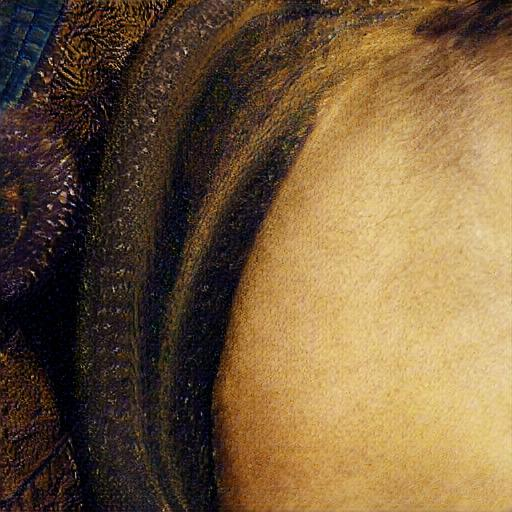

sample=49 iter=49 best: total=68.46 cos=68.44 reg=0.020 avg: total=71.99 cos=71.98 reg=0.015 std: total=2.41 cos=2.41 reg=0.006 1st=pillow(0.35) 2nd=dumbbell(0.10) 3rd=speedboat(0.08) components: >=0.5:0, >=0.3:1, >=0.1:2
Best index: 24
took: 270 secs (5.42 sec/iter) on GPU 0: GeForce RTX 2080 Ti (UUID: GPU-021ed8d3-0fd5-be42-d6fb-da929f4f9556)


In [16]:
for prompt in prompts:

    # seeding
    if seed == 0:
      seed = None

    # torch.manual_seed(np.random.randint(sys.maxsize))
    state = None if not seed else np.random.RandomState(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # initialization
    eps = 1e-8
    if 'sigmoid' in gen_model:
      noise_size = channels*sideY*sideX
      noise_vector = np.random.rand(pop_size, noise_size).astype(np.float32)
      noise_vector = np.log((noise_vector+eps)/(1-noise_vector+eps))
    else:
      noise_vector = truncnorm.rvs(-2*truncation, 2*truncation, size=(pop_size, noise_size), random_state=state).astype(np.float32) #see https://github.com/tensorflow/hub/issues/214

      if initial_class.lower() == 'random class':
        class_vector = np.ones(shape=(pop_size, class_size), dtype=np.float32)*class_smoothing/999
        class_vector[0,np.random.randint(class_size)] = 1-class_smoothing
      elif initial_class.lower() == 'random dirichlet':
        class_vector = dirichlet.rvs([pop_size/class_size] * class_size, size=1, random_state=state).astype(np.float32)
      elif initial_class.lower() == 'random mix':
        class_vector = np.random.rand(pop_size, class_size).astype(np.float32)
      elif initial_class.lower() == 'random embeddings':
        class_vector = np.random.randn(pop_size, class_size).astype(np.float32)
      else:
        if initial_class.lower() == 'from prompt':
          initial_class = prompt
        try:
          class_vector = None
          class_vector = one_hot_from_names(initial_class, batch_size=pop_size)
          assert class_vector is not None
          class_vector = class_vector*(1-class_smoothing*class_size/(class_size-1))+class_smoothing/(class_size-1)
        except Exception as e:  
          print('Error: could not find initial_class. Try something else.')
          raise e

      if initial_class.lower() != 'random embeddings':
        class_vector = class_vector/np.sum(class_vector,axis=-1, keepdims=True)
        class_vector = np.log(class_vector+eps)
      initial_class_vector = class_vector[0]
      if initial_class.lower() == 'random mix':
        initial_class_vector = initial_class_vector*0-np.log(class_size)
      if initial_class.lower() == 'random embeddings':
        initial_class_vector = initial_class_vector*0
      class_vector = torch.tensor(class_vector, requires_grad='SGD' in optimizer or 'Adam' in optimizer, device='cuda')
      smoothed_ent = -torch.tensor(class_smoothing*np.log(class_smoothing/999+eps)+(1-class_smoothing)*np.log(1-class_smoothing+eps), dtype=torch.float32).cuda()
    noise_vector = torch.tensor(noise_vector, requires_grad='SGD' in optimizer or 'Adam' in optimizer, device='cuda')

    if 'SGD' in optimizer or 'Adam' in optimizer:
      params = [noise_vector]
      if optimize_class:
        params = params + [class_vector]
      if 'SGD' in optimizer:
        optim = torch.optim.SGD(params, lr=learning_rate, momentum=0.9)  
      else:
        optim = torch.optim.Adam(params, lr=learning_rate)

    tx = clip.tokenize(prompt)
    with torch.no_grad():
      target_clip = perceptor.encode_text(tx.cuda())

    nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    if 'CMA' in optimizer:
      initial_vector = np.zeros(noise_size)
      bounds = None
      #if 'sigmoid' not in gen_model and not stochastic_truncation:
      #  bounds = [-2*truncation*np.ones(noise_size),2*truncation*np.ones(noise_size)]
      if optimize_class:
        initial_vector = np.hstack([initial_vector, initial_class_vector])
        #if not stochastic_truncation:
        #  bounds[0] = list(bounds[0]) + [None]*class_size
        #  bounds[1] = list(bounds[1]) + [None]*class_size
      cma_opts = {'popsize': pop_size, 'seed': np.nan, 'AdaptSigma': True, 'CMA_diagonal': True, 'CMA_active': False, 'CMA_elitist':False, 'bounds':bounds}
      cmaes = cma.CMAEvolutionStrategy(initial_vector, 1, inopts=cma_opts)

    # training
    sample_num = 0
    machine = !nvidia-smi -L
    start = time()

    for i in range(iterations):    
      if 'CMA' in optimizer:
        with torch.no_grad():
          cma_results = torch.tensor(cmaes.ask(), dtype=torch.float32).cuda()
          if optimize_class:
            noise_vector.data, class_vector.data = torch.split_with_sizes(cma_results, (noise_size, class_size), dim=-1)
            class_vector.data = class_vector.data
          else:
            noise_vector.data = cma_results      
      if 'SGD' in optimizer or 'Adam' in optimizer:
        losses = ascend_txt(i, grad_step=True, show_save='CMA' not in optimizer)
        assert noise_vector.requires_grad and noise_vector.is_leaf and (not optimize_class or class_vector.requires_grad and class_vector.is_leaf), (noise_vector.requires_grad, noise_vector.is_leaf, class_vector.requires_grad, class_vector.is_leaf)
      if 'CMA' in optimizer:
        with torch.no_grad():
          losses = ascend_txt(i, show_save=True)
          if optimize_class:
            vectors = torch.cat([noise_vector,class_vector], dim=1)
          else:
            vectors = noise_vector
          cmaes.tell(vectors.cpu().numpy(), losses)
      if i == iterations-1 or i % save_every == 0:
        print('took: %d secs (%.2f sec/iter) on %s'%(time()-start,(time()-start)/(i+1), machine[0]))

    newdir = outpath[:-1]+"_"+datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    !mv $outpath $newdir
    !mkdir -p $outpath

# Notes


Based on SIREN+CLIP Colabs by: [@advadnoun](https://twitter.com/advadnoun), [@norod78](https://twitter.com/norod78)

Other CLIP notebooks: [OpenAI tutorial](https://colab.research.google.com/github/openai/clip/blob/master/Interacting_with_CLIP.ipynb), [SIREN by @advadnoun](https://colab.research.google.com/drive/1FoHdqoqKntliaQKnMoNs3yn5EALqWtvP), [SIREN by @norod78](https://colab.research.google.com/drive/1K1vfpTEvAmxW2rnhAaALRVyis8EiLOnD), [BigGAN by @advadnoun](https://colab.research.google.com/drive/1NCceX2mbiKOSlAd_o7IU7nA9UskKN5WR), [BigGAN by @eyaler](j.mp/bigclip), [BigGAN by @tg_bomze](https://colab.research.google.com/github/tg-bomze/collection-of-notebooks/blob/master/Text2Image_v2.ipynb), [BigGAN using big-sleep library by @lucidrains](https://colab.research.google.com/drive/1MEWKbm-driRNF8PrU7ogS5o3se-ePyPb), [BigGAN story hallucinator by @bonkerfield](https://colab.research.google.com/drive/1jF8pyZ7uaNYbk9ZiVdxTOajkp8kbmkLK), [StyleGAN2-ADA Anime by @nagolinc](https://colab.research.google.com/github/nagolinc/notebooks/blob/main/TADNE_and_CLIP.ipynb) [v2](https://colab.research.google.com/github/nagolinc/notebooks/blob/main/CLIP_%2B_TADNE_(pytorch)_v2.ipynb)

Using the works:

https://github.com/openai/CLIP

https://tfhub.dev/deepmind/biggan-deep-512

https://github.com/huggingface/pytorch-pretrained-BigGAN

http://www.aiartonline.com/design-2019/eyal-gruss (WanderGAN)

For a curated list of more online generative tools see: [j.mp/generativetools](https://j.mp/generativetools)


# Leftovers

# ~0. One-Time Setup~

(UPDATE: all of this has been moved to the docker image on gitlab 2021-02)

In [17]:
# !nvidia-smi -L

# import subprocess

# CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
# print("CUDA version:", CUDA_version)

# if CUDA_version == "10.0":
#     torch_version_suffix = "+cu101"
# #     torch_version_suffix = "+cu100"
# elif CUDA_version == "10.1":
#     torch_version_suffix = "+cu101"
# elif CUDA_version == "10.2":
#     torch_version_suffix = ""
# else:
#     torch_version_suffix = "+cu110"

# !pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

In [18]:
# !pip install pytorch-pretrained-biggan
# !pip install nltk
# !pip install cma

In [19]:
# !sudo apt-get install -y ffmpeg

Install code repo for CLIP:

In [20]:
# !git clone --depth 1 https://github.com/openai/CLIP